In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
# pl.rcParams['xtick.labelsize'] = 7
# pl.rcParams['ytick.labelsize'] = 7
# pl.rcParams['axes.labelsize'] = 7
# pl.rcParams['axes.titlesize'] = 5
# pl.rcParams['legend.fontsize'] = 5
# pl.rcParams['xtick.labelsize'] = 5
# pl.rcParams['ytick.labelsize'] = 5
# pl.rcParams['font.size'] = 7

# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
NOTEBOOK_NAME = 'decoding_combined_vhpc_ncells_rw_csm'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
all_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
pre_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
post_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
pre_rev_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91'
post_rev_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'

epochs = '', '_early', '_mid', '_late'
sessions = 'pre','post','pre_rev','post_rev',

In [29]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)
    cv =LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(np.array(labels[ani])==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(np.array(labels[ani])==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = np.array(labels[ani])[which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = np.array(labels[ani])[which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    decoder.fit(patterns_comb_train, labels_comb)
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
    decoder.fit(patterns_comb_train, labels_comb)
    return decoder.score(patterns_comb_test, labels_comb)

In [30]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [31]:
sess_without = 'pre','post','pre_rev','post_rev',
sessions = '3odor_pre','3odor_post','3odor_pre_rev','3odor_post_rev',
for i in range(len(sessions)):

    exec("patterns_CS_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_odors_rw_csm/'%%ani)\
                                                  for ani in %s_animals]))"%(sess_without[i], sess_without[i], sessions[i], sess_without[i]))
    exec("labels_CS_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_odors_rw_csm/'%%ani)\
                                                  for ani in %s_animals]))"%(sess_without[i], sess_without[i], sessions[i], sess_without[i]))

In [32]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_pre', 'total_cells_post','total_cells_pre_rev','total_cells_post_rev']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_combined_vhpc_rw_csm/')
    exec('%s_vHPC = what'%(tot))
    print '%s_vHPC ='%(tot),
    print what

total_cells_pre_vHPC = 569
total_cells_post_vHPC = 676
total_cells_pre_rev_vHPC = 437
total_cells_post_rev_vHPC = 626


In [33]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_pre', 'total_cells_post','total_cells_pre_rev','total_cells_post_rev',]
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_combined_dhpc_rw_csm/')
    exec('%s_dHPC = what'%(tot))
    print '%s_dHPC ='%(tot),
    print what

total_cells_pre_dHPC = 790
total_cells_post_dHPC = 909
total_cells_pre_rev_dHPC = 919
total_cells_post_rev_dHPC = 703


In [34]:
sessions = 'pre','post','pre_rev','post_rev',
scores_CS = {}
n_loops = 100
for sess in sessions:
    n_cells = np.min((eval('total_cells_%s_vHPC'%sess), eval('total_cells_%s_dHPC'%sess)))
    scores_CS[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess), n_cells=n_cells)
                          for i in range(n_loops)]]

NameError: name 'expo_scores_CS' is not defined

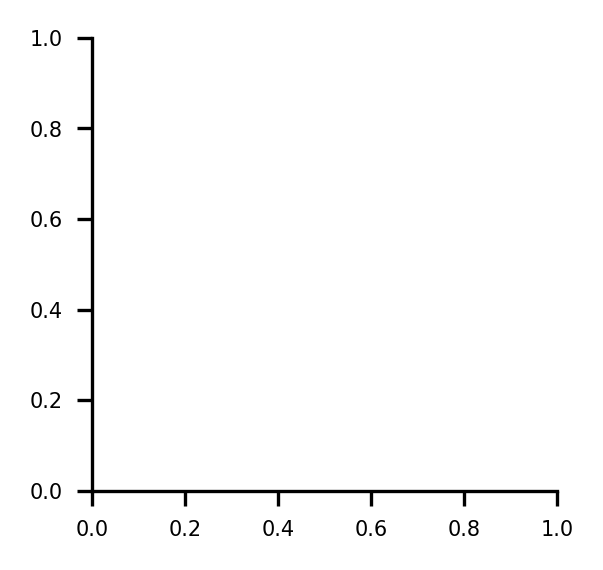

In [35]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
sessionsb = 'pre','post','ext1','ext2','reinstate','odor expo'
values = [scores_CS[sess]*100 for sess in sessions]
values.append(expo_scores_CS*100)
pt.plot_bars(values, ax=ax, colors = ['b','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessionsb)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessionsb, rotation=30)
ax.set_ylabel('CS decoding \ncombined FOV (%)')
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))

print 'dHPC20 removed from pre due to stellar behavioral performance (d\'=2)'
fig.savefig('../img/%s__bars_CS.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars_CS.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [ ]:
for sess in sessions:

    exec("patterns_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_odors_only_trace/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_odors_only_trace/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [ ]:
#have to extract 2_odor_expo varibles differently from that used above
patterns_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_evs','../%s/2_odor_expo/notebooks/autorestore/decoding_odors_only_trace'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_odors_only_trace'%ani)
                                                  for ani in expo_animals]))

In [ ]:
scores = {}
n_loops = 100
for sess in sessions:
    n_cells = np.min((eval('total_cells_%s_vHPC'%sess), eval('total_cells_%s_dHPC'%sess)))
    scores[sess] = np.r_[[do_test_within(eval("patterns_%s"%sess), eval("labels_%s"%sess),n_cells=n_cells)
                          for i in range(n_loops)]]

In [ ]:
expo_scores = {}
n_loops = 100
n_cells = np.min((total_cells_expo_vHPC, total_cells_expo_dHPC))
expo_scores = np.r_[[do_test_within(patterns_expo, labels_expo,n_cells=n_cells)
                          for i in range(n_loops)]]

In [ ]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
sessionsb = 'pre','post','ext1','ext2','reinstate','odor expo'
values = [scores[sess]*100 for sess in sessions]
values.append(expo_scores*100)
pt.plot_bars(values, ax=ax, colors = ['b','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessionsb)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessionsb, rotation=30)
ax.set_ylabel('Trace decoding \ncombined FOV (%)\n(cell# equalized)')
ax.set_ylim(0,100)
pvs = []
#pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
#pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))

print 'dHPC20 removed from pre due to stellar behavioral performance (d\'=2)'
fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [ ]:
# to examine trace decoding scores, use 'scores'. For CS decoding, use 'scores_CS'
# to examine a specific session, put name of the session in the [] (eg, ['renew'] to look at renew session)
print np.mean(scores['pre'])
print np.std(scores['pre'])
print sstats.sem(scores['pre'])

# now use global minimum for n cells

In [ ]:
scores_CS_gmin = {}
n_loops = 100
n_cells = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))
for sess in sessions:
    scores_CS_gmin[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess),n_cells=n_cells)
                          for i in range(n_loops)]]

In [ ]:
expo_scores_CS_gmin = {}
n_loops = 100
n_cells = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))
expo_scores_CS_gmin = np.r_[[do_test_within(patterns_CS_expo, labels_CS_expo,n_cells=n_cells)
                          for i in range(n_loops)]]

In [ ]:
scores_gmin = {}
n_loops = 100
n_cells = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))
for sess in sessions:
    scores_gmin[sess] = np.r_[[do_test_within(eval("patterns_%s"%sess), eval("labels_%s"%sess),n_cells=n_cells)
                          for i in range(n_loops)]]

In [ ]:
expo_scores_gmin = {}
n_loops = 100
n_cells = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_ext1_vHPC,total_cells_ext1_dHPC, total_cells_ext2_vHPC,total_cells_ext2_dHPC,
                total_cells_renew_vHPC,total_cells_renew_dHPC, total_cells_expo_vHPC,total_cells_expo_dHPC))
expo_scores_gmin = np.r_[[do_test_within(patterns_expo, labels_expo,n_cells=n_cells)
                          for i in range(n_loops)]]

In [ ]:
save_workspace(db)